In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# TERT and ALK in Neuroblastoma

Similar to MYCN, TERT and ALK have been implicated in somatic rearrangements for neuroblastoma.

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

TERT Hotspots: 1295228 and 1295250, or −124 and −146 bp from the ATG

Promoter locs:
* chr5:1295043-1295102 (UCSC EPDnew)
* chr5:1294943-1295291 [EH38E2352727](https://genome.ucsc.edu/cgi-bin/hgc?hgsid=1657774306_UK6gLD5UOjY5aZIEYcvtFme6jIuZ&db=hg38&c=chr5&l=1242691&r=1305544&o=1294942&t=1295291&g=encodeCcreCombined&i=EH38E2352727)


In [3]:
# we extract only the canonical splice variant
gene_gtfs = {}
gene_attrs = {"TERT": "TERT-201", "ALK": "ALK-201"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf


# TERT has a promoter that is often a hotspot region. The exactly location of this promoter is not entirely clear to 
# me after some light digging, so we defer to the larger region on UCSC: `chr5:1294943-1295291`
promoter_row = pd.Series(['chr5', 'HAVANA', 'promoter', 1295291, 1294943, '.', '-', '.', 'promoter'], index=gene_gtfs['TERT'].columns)

# Append the row using the loc indexer
gene_gtfs['TERT'] = gene_gtfs['TERT'].append(promoter_row, ignore_index=True)

# Load in SVs and samples

In [4]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.trio_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.trio_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,317,318,332,333,351,352,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

trio_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.trio_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
nbl_samples = metadata[(metadata["disease"] == "neuroblastoma") & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
nbl_samples = sorted(set(trio_samples) & set(nbl_samples))

control_samples = metadata[(metadata["neuroblastoma_control"]) & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
control_samples = sorted(set(trio_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(nbl_samples), len(control_samples)

(284, 2703)

# Identifying regions of interest



In [6]:
genes = {
    "TERT": ["chr5", 1253167, 1295068],
    "ALK": ["chr2", 29192774, 29921586]
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

Now we isolate the SVs in these regions

In [7]:
# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [8]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr2,20213515,47310672,PedSV.v2.3_INV_chr2_4,ALK
1,chr2,28693935,28694021,PedSV.v2.3_DUP_chr2_969,ALK


In [9]:
svs_in_regions.shape

(228, 5)

So it looks like there's a handful of SVs in this region. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [10]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [11]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr5,1630330,1630723,PedSV.v2.3_CPX_chr5_4,TERT
1,chr5,1630330,1630723,PedSV.v2.3_CPX_chr5_4,TERT
2,chr5,929471,934552,PedSV.v2.3_CPX_chr5_7,TERT
3,chr5,934124,934552,PedSV.v2.3_CPX_chr5_7,TERT
4,chr5,1238264,1238340,PedSV.v2.3_CPX_chr5_9,TERT
5,chr5,1512325,1512466,PedSV.v2.3_CPX_chr5_10,TERT
6,chr5,1512325,1512685,PedSV.v2.3_CPX_chr5_10,TERT
7,chr5,1583136,1583446,PedSV.v2.3_CPX_chr5_12,TERT
8,chr5,1779475,2041470,PedSV.v2.3_CPX_chr5_13,TERT
9,chr5,1779475,2225731,PedSV.v2.3_CPX_chr5_13,TERT


In [12]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(6, 5)

In [13]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(1)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,GROUPWISE_MASKED_GENOTYPES,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,...,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,EUR_AN,EUR_AC,EUR_AF,EUR_N_BI_GENOS,EUR_N_HOMREF,EUR_N_HET,EUR_N_HOMALT,EUR_FREQ_HOMREF,EUR_FREQ_HET,EUR_FREQ_HOMALT,EUR_CN_NUMBER,EUR_CN_COUNT,EUR_CN_FREQ,EUR_CN_NONREF_COUNT,EUR_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
47817,chr5,275034,275035,PedSV.v2.3_CPX_chr5_4,CPX,29,0.0021449699997901917,manta,13520,False,chr5,NaN,"INV_chr5:1630330-1630723,DUP_chr5:1630330-1630723",dDUP,275035,1630330.0,PE,NaN,NaN,False,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr5.final_cleanup_CPX_chr5_6,0.0,False,NaN,NaN,NaN,False,NaN,PDCD6,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,osteosarcoma_H3K27Ac_pe...",NaN,NaN,NaN,NaN,NaN,90.0,...,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,10732.0,26.0,0.002423,5366.0,5340.0,26.0,0.0,0.995155,0.004845,0.0,NaN,NaN,NaN,NaN,NaN,0.002423,1.0,0.004845,0.0,NaN,NaN,0.002299,0.997481,0.004598,0.0,NaN,NaN,0.00257,1.0,0.005139,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [14]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = 'name')

In [15]:
len(svs_in_regions_names)

229

So a decent number of SVs in this dataset fall within this region.


In [16]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             117
DUP              65
INS              15
INS:ME:ALU       13
CPX               6
INS:ME:SVA        5
INS:ME:LINE1      4
CNV               3
INV               1
Name: svtype, dtype: int64

We fetch all these SVs from the original dataset now and apply some filters. We have to handle CNVs a bit uniquely, because they exist in this dataset.

In [17]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. We overwrite AF for CNV to 1 arbitrarily
subset_svs['AF'] = subset_svs.apply(lambda row: float(row['AF']) if row['svtype'] != 'CNV' else row['CN_NONREF_FREQ'], axis = 1)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS            226
MULTIALLELIC      3
Name: FILTER, dtype: int64

Rare:
 True     184
False     45
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

In [19]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"].isin(["PASS", "MULTIALLELIC"]))
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(229, 954)

In [20]:
svs_to_keep["svtype"].value_counts()

DEL             117
DUP              65
INS              15
INS:ME:ALU       13
CPX               6
INS:ME:SVA        5
INS:ME:LINE1      4
CNV               3
INV               1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

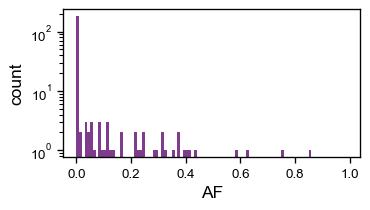

In [21]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [22]:
(svs_to_keep["AF"] < 0.01).value_counts()

True     184
False     45
Name: AF, dtype: int64

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [23]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_00Y8C0XA,PT_025YMME2,PT_06Z51EN5,PT_1PA8YT1W,PT_1X6CJ589,PT_2QB9MP9J,PT_2RZN4HR2,PT_397V1YW0,PT_39P91GFA,PT_4Y3P2N1P,PT_5E269C8Z,PT_5WAKHYY2,PT_7APMD0HG,PT_82D2FJV2,PT_8NPMDET9,PT_B5AW0HCW,PT_BZDPMBY4,PT_CBXEYWC5,PT_DYD0F9GP,PT_EHQ50Y19,PT_ESWCNGKM,PT_F2AFSP66,PT_F8GBEBH4,PT_FKE049G2,PT_FZ3XEWEK,PT_G1NQNTVQ,PT_GS8DC2DJ,PT_HJHZKCBX,PT_HS4P27SE,PT_J3VD4RFP,PT_JQGFY0SK,PT_K1E43YZQ,PT_KZG5PVKZ,PT_M1Z4XWW2,PT_M4ETZ912,PT_NPNW1RSB,PT_NSH5WBQ7,PT_P111JVHP,PT_P44YQ044,PT_PDYCQB6P,PT_PFRE83H3,PT_QFYDG6MK,...,TPMCCDG6295,TPMCCDG6311,TPMCCDG6379,TPMCCDG6405,TPMCCDG6421,TPMCCDG6659,TPMCCDG6773,TPMCCDG6978,TPMCCDG6997,TPMCCDG7107,TPMCCDG7191,TPMCCDG7220,TPMCCDG7521,TPMCCDG7553,TPMCCDG7653,TPMCCDG7655,TPMCCDG7678,TPMCCDG7773,TPMCCDG7784,TPMCCDG7849,TPMCCDG8022,TPMCCDG8128,TPMCCDG8399,TPMCCDG8529,TPMCCDG8550,TPMCCDG8609,TPMCCDG8663,TPMCCDG8711,TPMCCDG8725,TPMCCDG8762,TPMCCDG8792,TPMCCDG8801,TPMCCDG8819,TPMCCDG8862,TPMCCDG8876,TPMCCDG9065,TPMCCDG9097,TPMCCDG9139,TPMCCDG9227,TPMCCDG9240,TPMCCDG9262,TPMCCDG9290,TPMCCDG9295,TPMCCDG9357,TPMCCDG9392,TPMCCDG9464,TPMCCDG9654,TPMCCDG9683,TPMCCDG9686,TPMCCDG9902
1,PedSV.v2.3_DUP_chr2_969,ALK,0.001775,True,chr2,28693936,28694021,PedSV.v2.3_DUP_chr2_969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.v2.3_DEL_chr2_2518,ALK,0.000962,True,chr2,28718142,28718224,PedSV.v2.3_DEL_chr2_2518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since we now have CNVs, we have to handle this a bit more delicately. Let's first look at the CNVs in this dataset.

In [24]:
cnv_dosages = subsetted_gene_dosages[subsetted_gene_dosages['name'].str.contains('CNV')]
cnv_dosages

,name,gene,AF,rare,#chr,start,end,ID,PT_00Y8C0XA,PT_025YMME2,PT_06Z51EN5,PT_1PA8YT1W,PT_1X6CJ589,PT_2QB9MP9J,PT_2RZN4HR2,PT_397V1YW0,PT_39P91GFA,PT_4Y3P2N1P,PT_5E269C8Z,PT_5WAKHYY2,PT_7APMD0HG,PT_82D2FJV2,PT_8NPMDET9,PT_B5AW0HCW,PT_BZDPMBY4,PT_CBXEYWC5,PT_DYD0F9GP,PT_EHQ50Y19,PT_ESWCNGKM,PT_F2AFSP66,PT_F8GBEBH4,PT_FKE049G2,PT_FZ3XEWEK,PT_G1NQNTVQ,PT_GS8DC2DJ,PT_HJHZKCBX,PT_HS4P27SE,PT_J3VD4RFP,PT_JQGFY0SK,PT_K1E43YZQ,PT_KZG5PVKZ,PT_M1Z4XWW2,PT_M4ETZ912,PT_NPNW1RSB,PT_NSH5WBQ7,PT_P111JVHP,PT_P44YQ044,PT_PDYCQB6P,PT_PFRE83H3,PT_QFYDG6MK,...,TPMCCDG6295,TPMCCDG6311,TPMCCDG6379,TPMCCDG6405,TPMCCDG6421,TPMCCDG6659,TPMCCDG6773,TPMCCDG6978,TPMCCDG6997,TPMCCDG7107,TPMCCDG7191,TPMCCDG7220,TPMCCDG7521,TPMCCDG7553,TPMCCDG7653,TPMCCDG7655,TPMCCDG7678,TPMCCDG7773,TPMCCDG7784,TPMCCDG7849,TPMCCDG8022,TPMCCDG8128,TPMCCDG8399,TPMCCDG8529,TPMCCDG8550,TPMCCDG8609,TPMCCDG8663,TPMCCDG8711,TPMCCDG8725,TPMCCDG8762,TPMCCDG8792,TPMCCDG8801,TPMCCDG8819,TPMCCDG8862,TPMCCDG8876,TPMCCDG9065,TPMCCDG9097,TPMCCDG9139,TPMCCDG9227,TPMCCDG9240,TPMCCDG9262,TPMCCDG9290,TPMCCDG9295,TPMCCDG9357,TPMCCDG9392,TPMCCDG9464,TPMCCDG9654,TPMCCDG9683,TPMCCDG9686,TPMCCDG9902
97,PedSV.v2.3_CNV_chr5_7,TERT,0.357101,False,chr5,687851,780001,PedSV.v2.3_CNV_chr5_7,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,2.0
98,PedSV.v2.3_CNV_chr5_8,TERT,0.291568,False,chr5,740001,834001,PedSV.v2.3_CNV_chr5_8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,-1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,2.0,0.0,-1.0,0.0,0.0,2.0,-1.0,0.0,0.0,1.0,0.0,1.0,2.0
110,PedSV.v2.3_CNV_chr5_9,TERT,0.750000,False,chr5,827251,848001,PedSV.v2.3_CNV_chr5_9,0.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,1.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,0.0,4.0


And briefly, let's just look at the breakdowns:

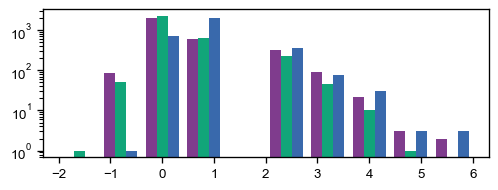

In [25]:
fig, ax = plt.subplots(1, figsize = (6, 2))
plt.hist(cnv_dosages.iloc[:, 8:].T)
plt.yscale('log')

So we should just be able to treat these as counts and put them in as genotypes. This will mess up some code we have later but it shouldn't be so hard to fix.

Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [26]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [nbl_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [27]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_-1,cases_0,cases_1,cases_2,cases_3,cases_4,cases_5,controls_-2,controls_-1,controls_0,controls_1,controls_2,controls_3,controls_4,controls_5,controls_6,midpoint
0,PedSV.v2.3_DUP_chr2_969,ALK,chr2,28693936,28694021,0.001775,True,0,283,1,0,0,0,0,0,0,2698,4,1,0,0,0,0,28693978.5
1,PedSV.v2.3_DEL_chr2_2518,ALK,chr2,28718142,28718224,0.000962,True,0,284,0,0,0,0,0,0,0,2701,2,0,0,0,0,0,28718183.0


We can see that the addition of the CNVs has thrown a bit of a wrench into this, but it's not too bad. We start by addressing the CNVs.

In [28]:
cnv_counts = case_control_sv_counts[case_control_sv_counts['name'].str.contains('CNV')].copy()
cnv_counts

,name,gene,#chr,start,end,AF,rare,cases_-1,cases_0,cases_1,cases_2,cases_3,cases_4,cases_5,controls_-2,controls_-1,controls_0,controls_1,controls_2,controls_3,controls_4,controls_5,controls_6,midpoint
96,PedSV.v2.3_CNV_chr5_7,TERT,chr5,687851,780001,0.357101,False,7,179,60,27,7,4,0,0,78,1731,521,271,80,17,3,2,733926.0
97,PedSV.v2.3_CNV_chr5_8,TERT,chr5,740001,834001,0.291568,False,3,209,48,19,4,1,0,1,41,1873,542,196,40,9,1,0,787001.0
109,PedSV.v2.3_CNV_chr5_9,TERT,chr5,827251,848001,0.750000,False,0,87,153,34,5,4,1,0,1,559,1739,310,65,24,2,3,837626.0


The metric similar to AF for CNVs is just average copy number, which we can easily calculate.

In [29]:
for label in ['cases', 'controls']:
    columns = [col for col in cnv_counts.columns if col.startswith(label)]
    genotypes = [int(c.split('_')[-1]) for c in columns]
    alleles = (cnv_counts[columns] * np.array(genotypes))
    average_cn = alleles.sum(axis = 1) / cnv_counts[columns].sum(axis = 1)
    
    # overwrite the value with cases and controls
    cnv_counts[f'average_CN_{label}'] = average_cn

In [30]:
cnv_counts

,name,gene,#chr,start,end,AF,rare,cases_-1,cases_0,cases_1,cases_2,cases_3,cases_4,cases_5,controls_-2,controls_-1,controls_0,controls_1,controls_2,controls_3,controls_4,controls_5,controls_6,midpoint,average_CN_cases,average_CN_controls
96,PedSV.v2.3_CNV_chr5_7,TERT,chr5,687851,780001,0.357101,False,7,179,60,27,7,4,0,0,78,1731,521,271,80,17,3,2,733926.0,0.507042,0.488346
97,PedSV.v2.3_CNV_chr5_8,TERT,chr5,740001,834001,0.291568,False,3,209,48,19,4,1,0,1,41,1873,542,196,40,9,1,0,787001.0,0.348592,0.389197
109,PedSV.v2.3_CNV_chr5_9,TERT,chr5,827251,848001,0.750000,False,0,87,153,34,5,4,1,0,1,559,1739,310,65,24,2,3,837626.0,0.904930,0.990381


One of those actually looks pretty interesting... in any case, we can now drop the CNV related content from the rest of our SVs to simplify things.

In [31]:
# gets rid of all non 0/1/2 genotypes
cnv_columns = [c for c in case_control_sv_counts.columns if '_' in c and c.split('_')[-1] not in ['0', '1', '2']]
case_control_sv_counts = case_control_sv_counts.drop(index = cnv_counts.index, columns = cnv_columns).reset_index(drop = True)

Now we can freely calculate AFs for the remainder of our SVs.

In [32]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    genotypes = [int(c.split('_')[-1]) for c in columns]
    assert genotypes == [0, 1, 2]
        
        
    # extract the genotypes from the column, e.g. cases_0 > 0
    genotypes = [int(c.split('_')[-1]) for c in columns]

    alt = (case_control_sv_counts[columns] * np.array(genotypes)).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [33]:
case_control_sv_counts

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,PedSV.v2.3_DUP_chr2_969,ALK,chr2,28693936,28694021,0.001775,True,283,1,0,2698,4,1,28693978.5,0.001761,0.001110
1,PedSV.v2.3_DEL_chr2_2518,ALK,chr2,28718142,28718224,0.000962,True,284,0,0,2701,2,0,28718183.0,0.000000,0.000370
2,PedSV.v2.3_INS_chr2_811,ALK,chr2,28741645,28741645,0.000074,True,283,1,0,2698,0,0,28741645.0,0.001761,0.000000
3,PedSV.v2.3_INS_chr2_812,ALK,chr2,28750563,28750563,0.000222,True,284,0,0,2701,1,0,28750563.0,0.000000,0.000185
4,PedSV.v2.3_DEL_chr2_2522,ALK,chr2,28786626,28787249,0.000074,True,283,0,0,2702,1,0,28786937.5,0.000000,0.000185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,PedSV.v2.3_DUP_chr5_288,TERT,chr5,1732045,1732125,0.235434,False,175,85,13,1372,1082,186,1732085.0,0.203297,0.275379
221,PedSV.v2.3_DUP_chr5_290,TERT,chr5,1763181,1763475,0.001321,True,278,1,0,2564,8,0,1763328.0,0.001792,0.001555
222,PedSV.v2.3_DUP_chr5_291,TERT,chr5,1765449,1765528,0.002811,True,281,3,0,2688,15,0,1765488.5,0.005282,0.002775
223,PedSV.v2.3_CPX_chr5_13,TERT,chr5,1779475,2225731,0.000074,True,284,0,0,2703,0,0,2002603.0,0.000000,0.000000


Any smoking guns in terms of SVs?

In [34]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
206,PedSV.v2.3_DUP_chr5_280,TERT,chr5,1623037,1623734,0.009842,True,253,17,0,2534,55,0,1623385.5,0.031481,0.010622
195,PedSV.v2.3_DUP_chr5_275,TERT,chr5,1603954,1604139,0.005918,True,268,10,0,2634,37,0,1604046.5,0.017986,0.006926
28,PedSV.v2.3_DEL_chr2_2566,ALK,chr2,29200016,29200127,0.005127,True,275,7,0,2666,23,0,29200071.5,0.012411,0.004277
136,PedSV.v2.3_DUP_chr5_173,TERT,chr5,975518,976185,0.000296,True,282,2,0,2703,0,0,975851.5,0.003521,0.000000


In [35]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
220,PedSV.v2.3_DUP_chr5_288,TERT,chr5,1732045,1732125,0.235434,False,175,85,13,1372,1082,186,1732085.0,0.203297,0.275379
145,PedSV.v2.3_DEL_chr5_450,TERT,chr5,1192088,1192846,0.249417,False,146,111,0,985,1639,0,1192467.0,0.215953,0.312309
216,PedSV.v2.3_DEL_chr5_569,TERT,chr5,1662952,1663184,0.315996,False,172,65,47,1314,719,670,1663068.0,0.279930,0.380873
217,PedSV.v2.3_DEL_chr5_570,TERT,chr5,1663376,1664137,0.314369,False,141,136,0,713,1869,90,1663756.5,0.245487,0.383421


## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


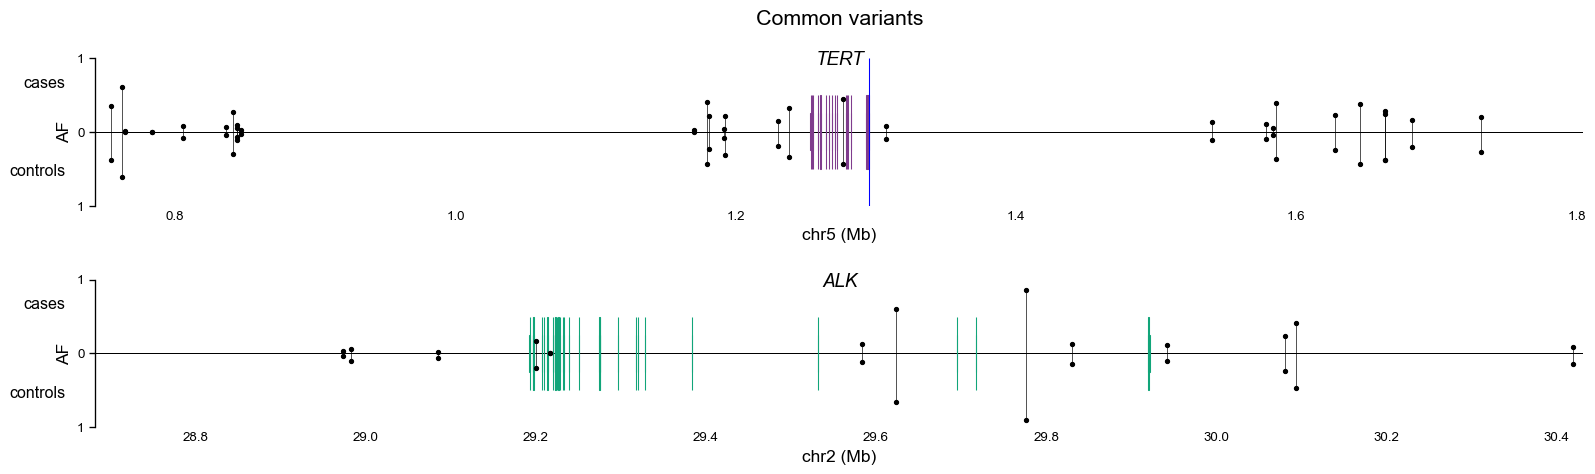

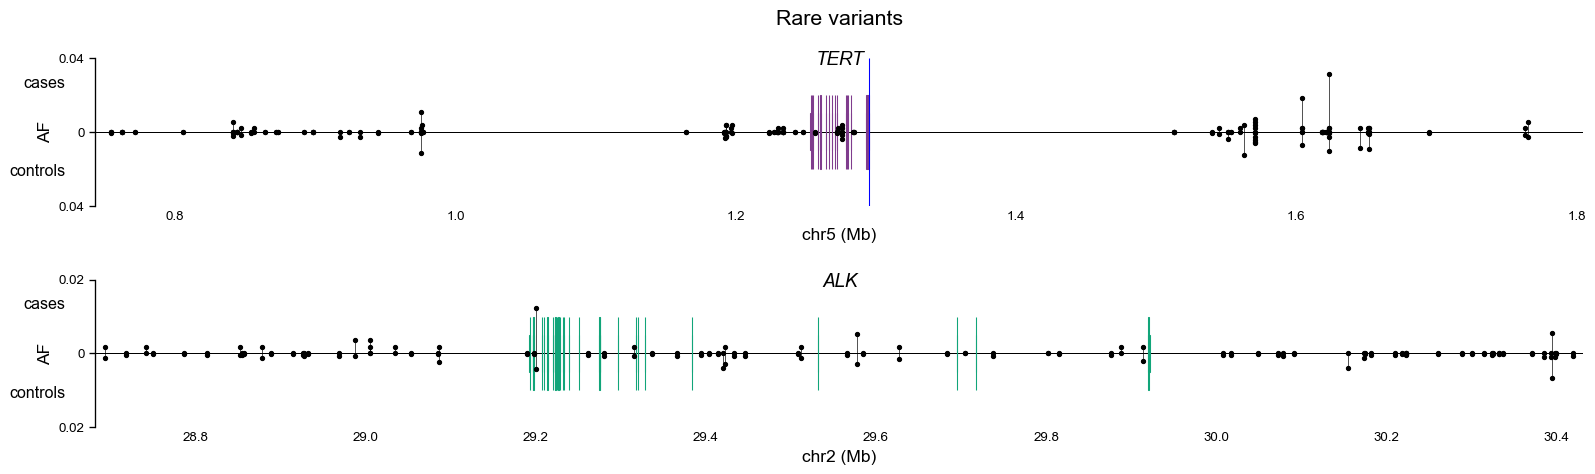

In [37]:
for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i], 'promoter': 'blue'}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5, "promoter": 1}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            features = ('exon', 'CDS', 'promoter'),
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.9)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/tert-alk-validation-{plot}.png")

And very quickly, let's do the same for CNVs. No common or rare this time, just showing copy number. And we get to just show TERT.

In [38]:
cnv_counts

,name,gene,#chr,start,end,AF,rare,cases_-1,cases_0,cases_1,cases_2,cases_3,cases_4,cases_5,controls_-2,controls_-1,controls_0,controls_1,controls_2,controls_3,controls_4,controls_5,controls_6,midpoint,average_CN_cases,average_CN_controls
96,PedSV.v2.3_CNV_chr5_7,TERT,chr5,687851,780001,0.357101,False,7,179,60,27,7,4,0,0,78,1731,521,271,80,17,3,2,733926.0,0.507042,0.488346
97,PedSV.v2.3_CNV_chr5_8,TERT,chr5,740001,834001,0.291568,False,3,209,48,19,4,1,0,1,41,1873,542,196,40,9,1,0,787001.0,0.348592,0.389197
109,PedSV.v2.3_CNV_chr5_9,TERT,chr5,827251,848001,0.750000,False,0,87,153,34,5,4,1,0,1,559,1739,310,65,24,2,3,837626.0,0.904930,0.990381


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Average\nCN')

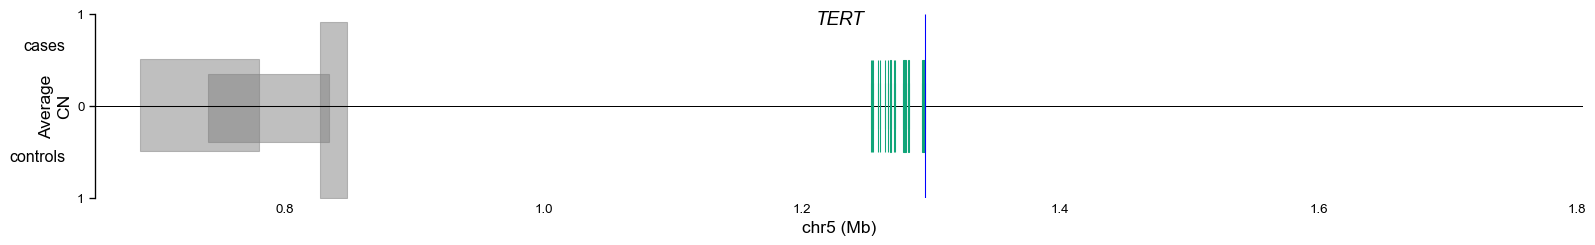

In [40]:
fig, ax = plt.subplots(1, 1,
    figsize=(20, 2.5),
)

g = 'TERT'

g_gtf = gene_gtfs[g]

# plot the genetic elements
feature_colors = {"exon": bold_10[i], "CDS": bold_10[i], 'promoter': 'blue'}
window = expanded_gene_locs.loc[g, ["start", "end"]].values
feature_span = {"exon": 0.25, "CDS": 0.5, "promoter": 1}

ax = sv_plot.plot_genomic_elements(
    ax,
    g_gtf,
    window=window,
    features = ('exon', 'CDS', 'promoter'),
    feature_span=feature_span,
    feature_colors=feature_colors,
    label=False,
)
aesthetics.strip_axis(ax=ax, x="label", y="ignore")

contig = expanded_gene_locs.loc[g, "chrom"]
ax.set_title(g, fontstyle="italic", y=0.9)

# plot the range of interest
ax.set_xlim(
    expanded_gene_locs.loc[g, ["start", "end"]].values
    + np.array([-100000, 10000])
)
ax.spines["bottom"].set_bounds(
    expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-100000, 0])
)

# add labels
ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

# switch to Mb
ax.set_xticklabels(ax.get_xticks() / 1e6)
ax.set_xlabel(f"{contig} (Mb)")

for index, row in cnv_counts.iterrows():
    start, end = row[['start', 'end']].values
    case_cn, control_cn = row[['average_CN_cases', 'average_CN_controls']].values
    ax.fill_between([start, end], [case_cn, case_cn], alpha = 0.5, color = 'grey')
    ax.fill_between([start, end], [-control_cn, -control_cn], alpha = 0.5, color = 'grey')

ax.set_yticks([-1, 0, 1])
ax.set_yticklabels([1, 0, 1])
ax.set_ylabel("Average\nCN")

# cnv_counts

#     fig.savefig(f"images/TERT-ALK-{plot}.png")

# A quick burden test

This is probably going to be significant, but we'll check anyway.

In [43]:
subsetted_gene_dosages = subsetted_gene_dosages[~subsetted_gene_dosages['name'].str.contains('CNV')]

In [44]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

Now we determine the dosages

In [45]:
# for rare, common, and combined variants, we count
for gene in ['TERT', 'ALK']:
    for rare in [True, False, 'combined']:

        if rare in [True, False]:
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["rare"] == rare)
                & (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare ' + gene if rare else 'common ' + gene
        elif rare == "combined":
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare + common ' + gene

        sv_counts = (gene_svs[nbl_samples + control_samples] > 0).sum(axis=0)

        model_data.loc[sv_counts.index, label] = sv_counts

Now we run the model

In [46]:
for gene in ['TERT', 'ALK']:
    for svtype in ['rare', 'common', 'rare + common']:

        column = svtype + ' ' + gene

        # run the model
        endog = model_data["disease"]
        exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
        model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)

        coeff = model.params[1]
        p = model.pvalues[1]
        print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)

        # also try a one-hot encoding
        exog[column] = (model_data[column] > 0).astype(int)

        try:
            one_hot_model = sm.Logit(
                endog,
                exog,
            ).fit(disp=0)
        except:
            print('Model failed')
            continue

        coeff = one_hot_model.params[1]
        p = one_hot_model.pvalues[1]
        print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare TERT coeff: 0.11404562163534032 p: 0.30898359885640103
SV one hot rare TERT coeff: 8.743841785684172e-05 p: 0.999556492043022
SV burden common TERT coeff: -0.19914937947463762 p: 3.0222477232296256e-13
Model failed
SV burden rare + common TERT coeff: -0.18211138855023198 p: 6.067782967564304e-12
Model failed
SV burden rare ALK coeff: 0.1420125134980941 p: 0.48447598998574204
SV one hot rare ALK coeff: 0.08664964747924295 p: 0.7004284755492749
SV burden common ALK coeff: -0.18753633097806185 p: 0.00013142931589921268
SV one hot common ALK coeff: 18.61196512530578 p: 0.9999468517139604
SV burden rare + common ALK coeff: -0.17409996722176516 p: 0.00030510256327879635
SV one hot rare + common ALK coeff: 18.61196512530578 p: 0.9999468517139604


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype. Note that this process also handles CNVs.

In [47]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + ['PC1', 'PC2', 'PC3']

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

In [48]:
model_data['disease'].value_counts()

0    2703
1     284
Name: disease, dtype: int64

Now we add the genotypes to this model data.

In [49]:
sv_dosages = subsetted_gene_dosages.set_index("name")[nbl_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [50]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(nbl_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # run the model
    try:
        endog = sv_model_data_nonna["disease"]
        exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

        # suppress some failure warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.Logit(
                endog=endog,
                exog=exog,
            ).fit(disp=0, method="bfgs", maxiter=1000)

        # store
        sv_models[sv] = model
        sv_results.append(
            [
                sv,
                model.pvalues[1],
                model.params[1],
                num_cases_dropped,
                num_controls_dropped,
            ]
        )

    except:
        sv_models[sv] = "fail"

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In [51]:
sv_results.head(2)

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
PedSV.v2.3_DUP_chr2_969,0.459365,0.733095,0,0
PedSV.v2.3_DEL_chr2_2518,0.985743,-9.535614,0,0


In [52]:
case_control_sv_counts = case_control_sv_counts.merge(sv_results.reset_index()[['name', 'p', 'coeff']], on = ['name'])

In [53]:
case_control_sv_counts.query('gene == "TERT" & p < 0.05')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls,p,coeff
96,PedSV.v2.3_DUP_chr5_153,TERT,chr5,754062,754618,0.371852,False,100,172,12,941,1429,332,754340.0,0.345070,0.387306,3.545080e-02,-0.212345
109,PedSV.v2.3_DEL_chr5_310,TERT,chr5,841020,841138,0.284721,False,127,150,1,1067,1611,6,841079.0,0.273381,0.302347,4.727259e-02,-0.253241
113,PedSV.v2.3_DUP_chr5_160,TERT,chr5,843855,843995,0.069822,False,258,26,0,2292,408,3,843925.0,0.045775,0.076582,4.952659e-02,-0.447706
140,PedSV.v2.3_DEL_chr5_436,TERT,chr5,1170364,1170741,0.010717,False,255,10,0,2495,40,0,1170552.5,0.018868,0.007890,1.058923e-02,0.943230
144,PedSV.v2.3_DEL_chr5_448,TERT,chr5,1191166,1192053,0.054407,False,232,20,0,2014,396,0,1191609.5,0.039683,0.082158,6.580268e-04,-0.821044
145,PedSV.v2.3_DEL_chr5_450,TERT,chr5,1192088,1192846,0.249417,False,146,111,0,985,1639,0,1192467.0,0.215953,0.312309,9.218676e-11,-0.872638
156,PedSV.v2.3_DUP_chr5_237,TERT,chr5,1229907,1230139,0.162593,False,207,75,2,1662,1003,37,1230023.0,0.139085,0.199297,2.372795e-04,-0.501218
162,PedSV.v2.3_CPX_chr5_9,TERT,chr5,1238380,1238380,0.327515,False,104,180,0,849,1851,3,1238380.0,0.316901,0.343507,2.295685e-02,-0.301285
176,PedSV.v2.3_DEL_chr5_491,TERT,chr5,1307364,1307507,0.088044,False,243,40,1,2188,502,12,1307435.5,0.073944,0.097335,3.221330e-02,-0.369467
195,PedSV.v2.3_DUP_chr5_275,TERT,chr5,1603954,1604139,0.005918,True,268,10,0,2634,37,0,1604046.5,0.017986,0.006926,1.878967e-02,0.895778


So there's a lot of activity around TERT. Let's see where it localizes.

We load in the discovery cohort here as well.

In [58]:
discovery = pd.read_csv('data/tert-alk-discovery-cohort-significant-loci-v2.3.csv')
merged_dis_val = case_control_sv_counts.merge(discovery[['name', 'p', 'coeff']], 
                                              on = ['name'], suffixes = ['_validation', '_discovery'])
validated_hits = merged_dis_val.query('p_discovery < 0.000125 & p_validation < 0.05')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


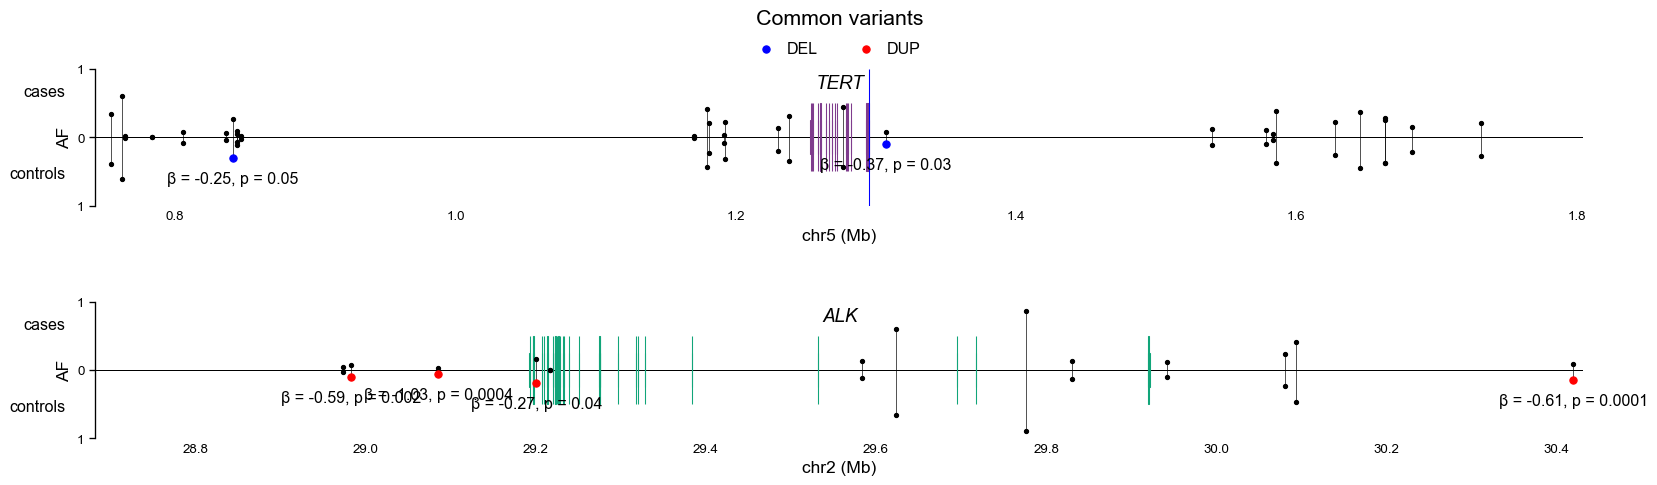

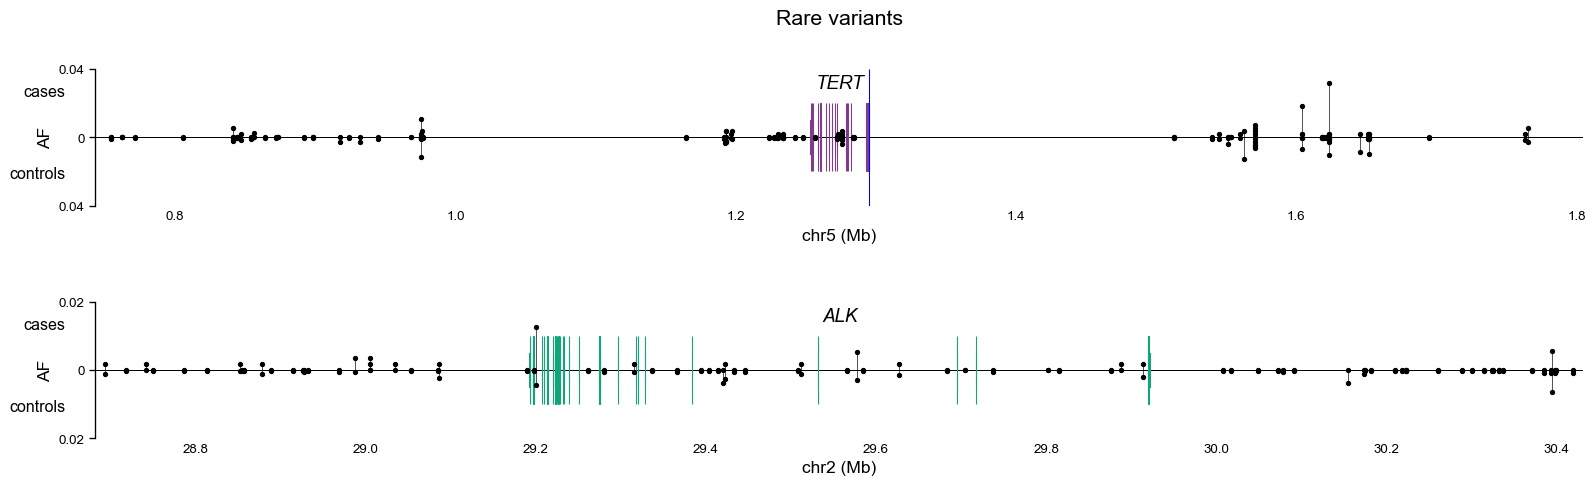

In [59]:
sv_colors = {"DEL": "blue", "DUP": "red", "INS": bold_10[0], 'CPX': 'green'}

for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.7},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i], 'promoter': 'blue'}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5, 'promoter': 1}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            features=['exon', 'CDS', 'promoter'],
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    legend_handles = {}
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for j in range(len(gene_data)):
            loc = gene_data["midpoint"][j]
            name = gene_data["name"][j]

            case, control = case_y[j], control_y[j]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

            # look up the p value of the sv, if it exists
            if name in validated_hits['name'].to_list():
                p_val, coeff = merged_dis_val.set_index('name').loc[name, ["p_validation", "coeff_validation"]]

                if p_val < 0.05:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 if coeff > 0 else y - 0.3

                    sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=30, zorder=3, label=sv_type
                    )

                    if sv_type in ["DUP", "DEL", "CPX", "INS"]:
                        legend_handles[sv_type] = scatter

                    # add text for coeff
                    ax.text(
                        x=loc,
                        y=text_y,
                        s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                        ha="center",
                        va="center",
                    )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.3,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    axes[0].legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0.43, 1.15),
        ncol=2,
        handletextpad=0.3,
    )

    fig.savefig(f"images/tert-alk-validation-significance-{plot}.png")